<a href="https://colab.research.google.com/github/LuisRobles18/CSC6850ML/blob/main/Machine_Learning_Project_(Classification_1_6_and_MultiLabel_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning - Classification (Datasets 1 - 6)**

**Classification:** Classification is to identify which category a new observation belongs to, on the basis of a training dataset. There are five datasets. For each dataset, we provide the training dataset, training label, and test dataset. Please use the training dataset and training label to build your classifier and predict the test label. A class label is represented by an integer. For example, in the 1st dataset, there are 4 classes where 1 represents the 1st class, 2 represents the 2nd class, etc. Note that, there exist some missing values in some of the dataset (a missing entry is filled by *1.00000000000000e+99*), please fill the missing values before perform your classification algorithm.

In [ ]:
#Importing all modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cvxopt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import seaborn as sns
from sklearn import svm
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

##**Filling Missing values (Datasets 1-6)**

*   **TrainData 1** contains *3312* features with *150* samples. **Testdata1** contains *3312* features with *53* samples. There are *5* classes in this dataset.
*   **TrainData 2** contains *9182* features with *100* samples. **Testdata2** contains *9182* features with *74* samples. There are *11* classes in this dataset.
*   **TrainData 3** contains *13*  features with *6300* samples. **Testdata3** contains *13* features with *2693* samples. There are *9* classes in this dataset.
*   **TrainData 4** contains *112* features with *2547* samples. **Testdata4** contains *112* features with *1092* samples. There are *9* classes in this dataset.
*   **TrainData 5** contains *11* features with *1119* samples. **Testdata5** contains *11* features with *480* samples. There are *6* classes in this dataset.
*   **TrainData 6** contains *142* features with *612* samples. **Testdata6** contains *142* features with *262* samples. This is not a classification problem. You are asked to predict the real value. (Graduate Students Only)



##**Classifying Dataset 1**

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

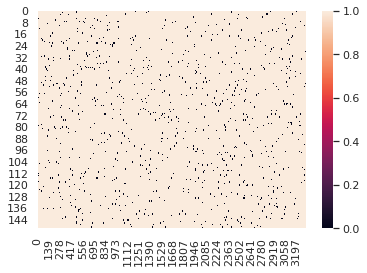

In [ ]:
#Importing the TrainingData1 dataset
df_1 = pd.read_csv('TrainData1.txt', sep='\t', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_1.index:
  for j in range(len(df_1.columns)):
    if df_1[j][i] == 1e+99:
      df_1[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_1.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are empty cells in the dataset (dark spots represents empty values), therefore we will fill these values by calculating the per-column average on from each class.

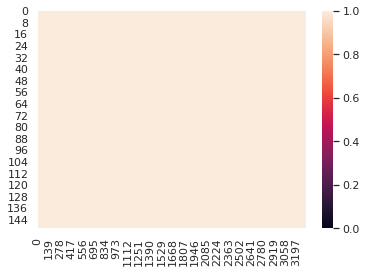

In [ ]:
#Firstly, we merge the dataset with the label column
df_1_label = pd.read_csv('TrainLabel1.txt', sep='\r\n', header = None)
df_1['Label'] = df_1_label[0]

df_1_by_class = []
#We get all possible target values
class_list = sorted(df_1['Label'].unique())
#We group the rows by class
for i in range(len(class_list)):
  df_1_by_class.append(df_1.loc[df_1['Label'] == class_list[i]])

#For each row class, we separate them by complete and incomplete rows
#in order to calculate the average per column and assign it to the empty cells
for i in range(len(class_list)):
  for j in range(len(df_1_by_class[i].columns)-1): 
    sum_column = 0
    count_rows = 0
    average_per_column = 0.0
    for index,row in df_1_by_class[i].iterrows():
      if pd.isnull(row[j]):
        sum_column = sum_column
      else:
        sum_column += row[j]
        count_rows += 1
    average_per_column = sum_column/count_rows * 1.0

    #We assign the values to the empty cells from the current column
    for index,row in df_1_by_class[i].iterrows():
      if pd.isnull(row[j]):
        df_1_by_class[i][j][index] = average_per_column

#We join back the splitted dataset to a new one
frames = []
for i in range(len(class_list)):
  frames.append(df_1_by_class[i])
df_1 = pd.concat(frames)

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_1.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

df_1 = df_1.sort_index()

###**Defining the SVM model**

**NOTE:** This will be used for datasets 1 to 5

In [ ]:
#We define the linear function for the kernel
def linear(x, z):
    return np.dot(x, z.T)

#We create the SVM class
class SVM:
    def __init__(self, kernel=linear, C=1):
        self.kernel = kernel
        self.C = C

    #This function is for the training process
    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        #In this part we calculate the Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

    #This function is used once the training process is done
    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

###**Training process using SVM and Euclidean Distance**

**NOTE:** Two approaches will be implemented in order to select the one that performs better.

In [ ]:
#================ Training SVM Model ===================
X_train, X_val, y_train, y_val = train_test_split(df_1.iloc[:, :len(df_1.columns)-1], df_1.iloc[: , -1], test_size=0.20, random_state=42)

print("Building Support Vector Machines Model...")
model_svm_1 =svm.SVC(kernel = 'linear')
model_svm_1.fit(X_train, y_train)
pickle.dump(model_svm_1, open('SVM_1.pickle', 'wb'))
model_svm_1_labels = model_svm_1.predict(X_val)

model_svm_1_classification_report = classification_report(y_val, model_svm_1_labels)
print("\n\033[1mSupport Vector Machines- Performance metrics \n")
print(model_svm_1_classification_report)

print("Classifying rows using Euclidean distance...")
#Classifying rows using Euclidean distance where K = number of classes + 1
k_value = int(df_1.nunique()['Label'])+1
nearest_rows_index = []
nearest_rows_distance = []
target_values = []
for index,row in X_val.iterrows():
  #print("Current index: "+str(index))
  for index2,row2 in X_train.iterrows():
    #We calculate the distance for each column
    cumulative_sum = 0
    for i in range(len(X_val.columns)):
      cumulative_sum += math.pow(abs(row2[i]-row[i]),2)
    distance = math.sqrt(cumulative_sum)

    #If list of nearest rows is less than k_value, we add this
    if(len(nearest_rows_distance) < k_value):
      nearest_rows_index.append(index2)
      nearest_rows_distance.append(distance)
    else:
      #We check if the large value is greater than the current distance
      max_value = max(nearest_rows_distance)
      max_index = nearest_rows_distance.index(max_value)

      if(max_value > distance):
        nearest_rows_index[max_index] = int(index2)
        nearest_rows_distance[max_index] = distance
  #print("The row at the given index has a similarity with the following index: ")
  #print(nearest_rows_index)
  #print("Their respective distance values are: ")
  #print(nearest_rows_distance)

  #Now we get the counts for each class from each of the closest rows
  temp_label_counts = {}
  for i in range(len(nearest_rows_index)):
    current_label = df_1.iloc[[nearest_rows_index[i]]]['Label'].to_list()[0]
    if current_label in temp_label_counts:
        temp_label_counts[current_label] += 1
    else:
        temp_label_counts[current_label] = 1
  
  #We get the maximum value from the dictionary
  max_value = max(temp_label_counts, key=temp_label_counts.get)
  
  #We add the predicted class to the target list
  target_values.append(max_value)

model_ed_1_classification_report = classification_report(y_val, target_values)
print("\n\033[1mEuclidean Distance- Performance metrics \n")
print(model_ed_1_classification_report)    


Building Support Vector Machines Model...

Support Vector Machines- Performance metrics 

              precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           0.97        30
   macro avg       0.99      0.93      0.96        30
weighted avg       0.97      0.97      0.96        30

Classifying rows using Euclidean distance...

Euclidean Distance- Performance metrics 

              precision    recall  f1-score   support

           1       0.81      1.00      0.90        22
           2       0.67      0.67      0.67         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    acc

###**Confusion Matrix (SVM and Euclidean distance)**

In the following plot, we can see the predicted labels vs true labels matrix obtained from both the SVM model and the Euclidean distance approach. 

**SVM - Confusion Matrix**

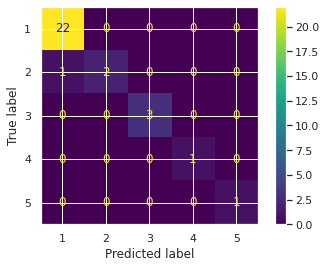

In [ ]:
cm = confusion_matrix(y_val, model_svm_1_labels, labels=sorted(df_1['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_1['Label'].unique()))
disp.plot()

**Euclidean Distance - Confusion Matrix**

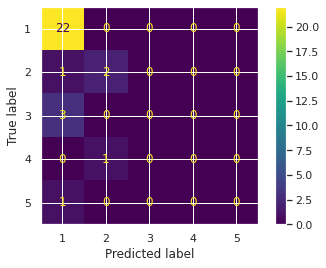

In [ ]:
cm = confusion_matrix(y_val, target_values, labels=sorted(df_1['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_1['Label'].unique()))
disp.plot()

###**Classifying rows from the test dataset using the approach with better performance (SVM)**

Since SVM performed better, we will classify the rows from the testing dataset. But first, we need to make sure that the dataset doesn't have empty cells.

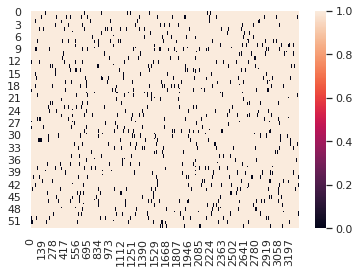

In [ ]:
#Importing the TestData1 dataset
df_1_test = pd.read_csv('TestData1.txt', sep='\t', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_1_test.index:
  for j in range(len(df_1_test.columns)):
    if df_1_test[j][i] == 1e+99:
      df_1_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_1_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are empty cells in the test dataset, therefore we will fill these values by calculating the per-column average.

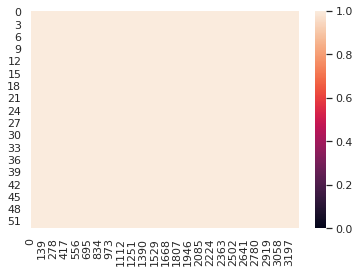

In [ ]:
#We will fill the empty values from the test dataset based on the column average
for j in range(len(df_1_test.columns)): 
  sum_column = 0
  count_rows = 0
  average_per_column = 0.0
  for index,row in df_1_test.iterrows():
    if pd.isnull(row[j]):
      sum_column = sum_column
    else:
      sum_column += row[j]
      count_rows += 1
  average_per_column = sum_column/count_rows * 1.0

  #We assign the values to the empty cells from the current column
  for index,row in df_1_test.iterrows():
    if pd.isnull(row[j]):
      df_1_test[j][index] = average_per_column

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_1_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

df_1_test = df_1_test.sort_index()

Now that there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
model_svm_1_labels_test = model_svm_1.predict(df_1_test)
#We export the target values from each row from the test dataset to a TXT file
with open("RoblesHernandezClassification1.txt", 'w') as f:
    f.write("\n".join(map(str, model_svm_1_labels_test)))

##**Classifying Dataset 2**

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

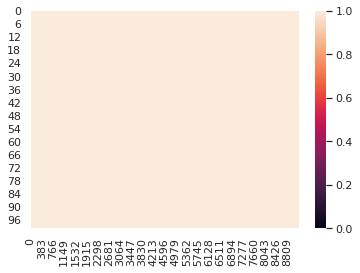

In [ ]:
#Importing the TrainingData2 dataset
df_2 = pd.read_csv('TrainData2.txt', sep='   ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_2.index:
  for j in range(len(df_2.columns)):
    if df_2[j][i] == 1e+99:
      df_2[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_2.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are no empty cells in the dataset, therefore we can continue to merge the label column with the current dataset.

In [ ]:
#Merging training dataset with the label column
#Importing the TrainLabel5 data
df_2_label = pd.read_csv('TrainLabel2.txt', sep='\r\n', header = None)
df_2['Label'] = df_2_label[0]

###**Training process using SVM and Euclidean Distance**

**NOTE:** Two approaches will be implemented in order to select the one that performs better.

In [ ]:
#================ Training SVM Model ===================
X_train, X_val, y_train, y_val = train_test_split(df_2.iloc[:, :len(df_2.columns)-1], df_2.iloc[: , -1], test_size=0.20, random_state=42)

print("Building Support Vector Machines Model...")
model_svm_2 =svm.SVC(kernel = 'linear')
model_svm_2.fit(X_train, y_train)
pickle.dump(model_svm_2, open('SVM_2.pickle', 'wb'))
model_svm_2_labels = model_svm_2.predict(X_val)

model_svm_2_classification_report = classification_report(y_val, model_svm_2_labels)
print("\n\033[1mSupport Vector Machines- Performance metrics \n")
print(model_svm_2_classification_report)

print("Classifying rows using Euclidean distance...")
#Classifying rows using Euclidean distance where K = number of classes + 1
k_value = int(df_2.nunique()['Label'])+1
nearest_rows_index = []
nearest_rows_distance = []
target_values = []
for index,row in X_val.iterrows():
  #print("Current index: "+str(index))
  for index2,row2 in X_train.iterrows():
    #We calculate the distance for each column
    cumulative_sum = 0
    for i in range(len(X_val.columns)):
      cumulative_sum += math.pow(abs(row2[i]-row[i]),2)
    distance = math.sqrt(cumulative_sum)

    #If list of nearest rows is less than k_value, we add this
    if(len(nearest_rows_distance) < k_value):
      nearest_rows_index.append(index2)
      nearest_rows_distance.append(distance)
    else:
      #We check if the large value is greater than the current distance
      max_value = max(nearest_rows_distance)
      max_index = nearest_rows_distance.index(max_value)

      if(max_value > distance):
        nearest_rows_index[max_index] = int(index2)
        nearest_rows_distance[max_index] = distance
  #print("The row at the given index has a similarity with the following index: ")
  #print(nearest_rows_index)
  #print("Their respective distance values are: ")
  #print(nearest_rows_distance)

  #Now we get the counts for each class from each of the closest rows
  temp_label_counts = {}
  for i in range(len(nearest_rows_index)):
    current_label = df_2.iloc[[nearest_rows_index[i]]]['Label'].to_list()[0]
    if current_label in temp_label_counts:
        temp_label_counts[current_label] += 1
    else:
        temp_label_counts[current_label] = 1
  
  #We get the maximum value from the dictionary
  max_value = max(temp_label_counts, key=temp_label_counts.get)
  
  #We add the predicted class to the target list
  target_values.append(max_value)

model_ed_2_classification_report = classification_report(y_val, target_values)
print("\n\033[1mEuclidean Distance- Performance metrics \n")
print(model_ed_2_classification_report)    


Building Support Vector Machines Model...

Support Vector Machines- Performance metrics 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       0.00      0.00      0.00         0

    accuracy                           0.95        20
   macro avg       0.90      0.85      0.87        20
weighted avg       1.00      0.95      0.97        20

Classifying rows using Euclidean distance...

Euclidean Distance- Performance metrics 

              precision    recall  f1-score   support

        

###**Confusion Matrix (SVM and Euclidean distance)**

In the following plot, we can see the predicted labels vs true labels matrix obtained from both the SVM model and the Euclidean distance approach. 

**SVM - Confusion Matrix**

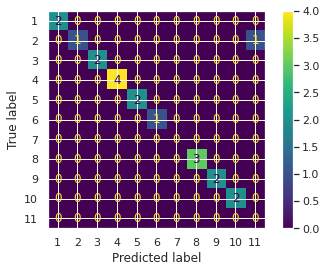

In [ ]:
cm = confusion_matrix(y_val, model_svm_2_labels, labels=sorted(df_2['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_2['Label'].unique()))
disp.plot()

**Euclidean distance - Confusion Matrix**

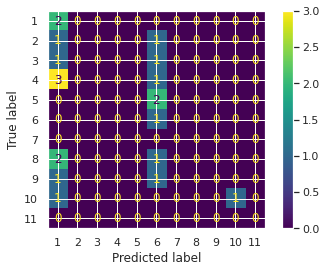

In [ ]:
cm = confusion_matrix(y_val, target_values, labels=sorted(df_2['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_2['Label'].unique()))
disp.plot()

###**Classifying rows from the test dataset using the approach with better performance (SVM)**

Since SVM performed better, we will classify the rows from the testing dataset. But first, we need to make sure that the dataset doesn't have empty cells.

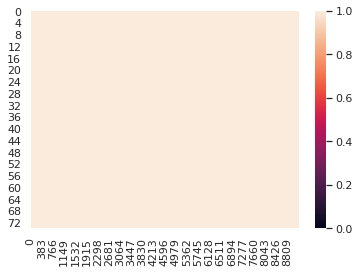

In [ ]:
#Importing the TestData2 dataset
df_2_test = pd.read_csv('TestData2.txt', sep='   ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_2_test.index:
  for j in range(len(df_2_test.columns)):
    if df_2_test[j][i] == 1e+99:
      df_2_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_2_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

Since there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
model_svm_2_labels_test = model_svm_2.predict(df_2_test)
#We export the target values from each row from the test dataset to a TXT file
with open("RoblesHernandezClassification2.txt", 'w') as f:
    f.write("\n".join(map(str, model_svm_2_labels_test)))

##**Classifying Dataset 3**

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

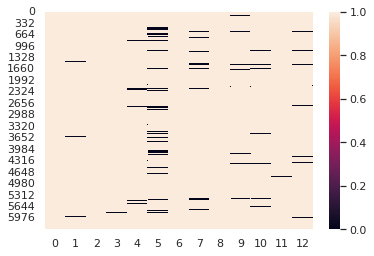

In [ ]:
#Importing the TrainingData4 dataset
df_3 = pd.read_csv('TrainData3.txt', sep='\t', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_3.index:
  for j in range(len(df_3.columns)):
    if df_3[j][i] == 1e+99:
      df_3[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_3.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are empty cells in the dataset (dark spots represents empty values), therefore we will fill these values by calculating the per-column average on from each class.

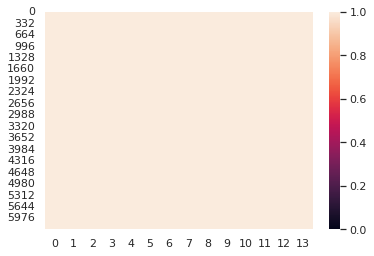

In [ ]:
#Firstly, we merge the dataset with the label column
df_3_label = pd.read_csv('TrainLabel3.txt', sep='\r\n', header = None)
df_3['Label'] = df_3_label[0]

df_3_by_class = []
#We get all possible target values
class_list = sorted(df_3['Label'].unique())
#We group the rows by class
for i in range(len(class_list)):
  df_3_by_class.append(df_3.loc[df_3['Label'] == class_list[i]])

#For each row class, we separate them by complete and incomplete rows
#in order to calculate the average per column and assign it to the empty cells
for i in range(len(class_list)):
  for j in range(len(df_3_by_class[i].columns)-1): 
    sum_column = 0
    count_rows = 0
    average_per_column = 0.0
    for index,row in df_3_by_class[i].iterrows():
      if pd.isnull(row[j]):
        sum_column = sum_column
      else:
        sum_column += row[j]
        count_rows += 1
    average_per_column = sum_column/count_rows * 1.0

    #We assign the values to the empty cells from the current column
    for index,row in df_3_by_class[i].iterrows():
      if pd.isnull(row[j]):
        df_3_by_class[i][j][index] = average_per_column

#We join back the splitted dataset to a new one
frames = []
for i in range(len(class_list)):
  frames.append(df_3_by_class[i])
df_3 = pd.concat(frames)

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_3.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

df_3 = df_3.sort_index()

###**Training process using SVM and Euclidean Distance**

**NOTE:** Two approaches will be implemented in order to select the one that performs better.

In [ ]:
#================ Training SVM Model ===================
X_train, X_val, y_train, y_val = train_test_split(df_3.iloc[:, :len(df_3.columns)-1], df_3.iloc[: , -1], test_size=0.20, random_state=42)

print("Building Support Vector Machines Model...")
model_svm_3 =svm.SVC(kernel = 'linear')
model_svm_3.fit(X_train, y_train)
pickle.dump(model_svm_3, open('SVM_3.pickle', 'wb'))
model_svm_3_labels = model_svm_3.predict(X_val)

model_svm_3_classification_report = classification_report(y_val, model_svm_3_labels)
print("\n\033[1mSupport Vector Machines- Performance metrics \n")
print(model_svm_3_classification_report)

print("Classifying rows using Euclidean distance...")
#Classifying rows using Euclidean distance where K = number of classes + 1
k_value = int(df_3.nunique()['Label'])+1
nearest_rows_index = []
nearest_rows_distance = []
target_values = []
for index,row in X_val.iterrows():
  #print("Current index: "+str(index))
  for index2,row2 in X_train.iterrows():
    #We calculate the distance for each column
    cumulative_sum = 0
    for i in range(len(X_val.columns)):
      cumulative_sum += math.pow(abs(row2[i]-row[i]),2)
    distance = math.sqrt(cumulative_sum)

    #If list of nearest rows is less than k_value, we add this
    if(len(nearest_rows_distance) < k_value):
      nearest_rows_index.append(index2)
      nearest_rows_distance.append(distance)
    else:
      #We check if the large value is greater than the current distance
      max_value = max(nearest_rows_distance)
      max_index = nearest_rows_distance.index(max_value)

      if(max_value > distance):
        nearest_rows_index[max_index] = int(index2)
        nearest_rows_distance[max_index] = distance
  #print("The row at the given index has a similarity with the following index: ")
  #print(nearest_rows_index)
  #print("Their respective distance values are: ")
  #print(nearest_rows_distance)

  #Now we get the counts for each class from each of the closest rows
  temp_label_counts = {}
  for i in range(len(nearest_rows_index)):
    current_label = df_3.iloc[[nearest_rows_index[i]]]['Label'].to_list()[0]
    if current_label in temp_label_counts:
        temp_label_counts[current_label] += 1
    else:
        temp_label_counts[current_label] = 1
  
  #We get the maximum value from the dictionary
  max_value = max(temp_label_counts, key=temp_label_counts.get)
  
  #We add the predicted class to the target list
  target_values.append(max_value)

model_ed_3_classification_report = classification_report(y_val, target_values)
print("\n\033[1mEuclidean Distance- Performance metrics \n")
print(model_ed_3_classification_report)    


Building Support Vector Machines Model...

Support Vector Machines- Performance metrics 

              precision    recall  f1-score   support

           1       0.52      0.84      0.64       249
           2       0.22      0.12      0.16       109
           3       0.15      0.03      0.05        93
           4       0.17      0.15      0.16       113
           5       0.00      0.00      0.00        92
           6       0.19      0.27      0.22       147
           7       0.15      0.05      0.08       134
           8       0.32      0.68      0.43       200
           9       0.00      0.00      0.00       123

    accuracy                           0.33      1260
   macro avg       0.19      0.24      0.19      1260
weighted avg       0.24      0.33      0.26      1260

Classifying rows using Euclidean distance...

Euclidean Distance- Performance metrics 

              precision    recall  f1-score   support

           1       1.00      0.01      0.02       249
        

###**Confusion Matrix (SVM and Euclidean distance)**

In the following plot, we can see the predicted labels vs true labels matrix obtained from both the SVM model and the Euclidean distance approach. 

**SVM - Confusion Matrix**

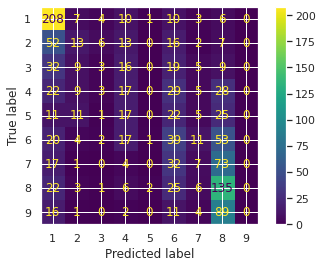

In [ ]:
cm = confusion_matrix(y_val, model_svm_3_labels, labels=sorted(df_3['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_3['Label'].unique()))
disp.plot()

**Euclidean distance - Confusion Matrix**

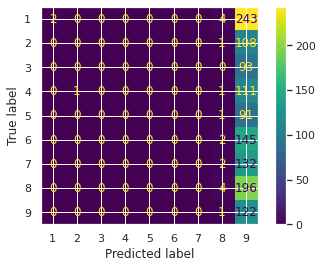

In [ ]:
cm = confusion_matrix(y_val, target_values, labels=sorted(df_3['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_3['Label'].unique()))
disp.plot()

###**Classifying rows from the test dataset using the approach with better performance (SVM)**

Since SVM performed better, we will classify the rows from the testing dataset. But first, we need to make sure that the dataset doesn't have empty cells.

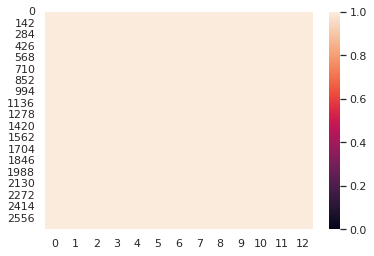

In [ ]:
#Importing the TestData3 dataset
df_3_test = pd.read_csv('TestData3.txt', sep=',', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_3_test.index:
  for j in range(len(df_3_test.columns)):
    if df_3_test[j][i] == 1e+99:
      df_3_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_3_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

Since there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
model_svm_3_labels_test = model_svm_3.predict(df_3_test)
#We export the target values from each row from the test dataset to a TXT file
with open("RoblesHernandezClassification3.txt", 'w') as f:
    f.write("\n".join(map(str, model_svm_3_labels_test)))

##**Classifying Dataset 4**

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

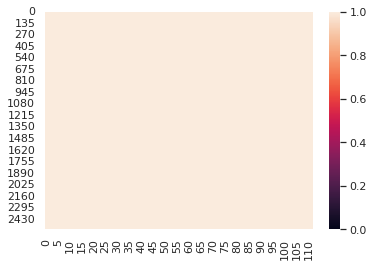

In [ ]:
#Importing the TraininData4 dataset
df_4 = pd.read_csv('TrainData4.txt', sep='  ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_4.index:
  for j in range(len(df_4.columns)):
    if df_4[j][i] == 1e+99:
      df_4[j][i] = np.nan

import numpy as np; 
np.random.seed(0)
import seaborn as sns; 
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_4.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are no empty cells in the dataset, therefore we can continue to merge the label column with the current dataset.

In [ ]:
#Merging training dataset with the label column
#Importing the TrainLabel4 data
df_4_label = pd.read_csv('TrainLabel4.txt', sep='\r\n', header = None)
df_4['Label'] = df_4_label[0]

###**Training process using SVM and Euclidean Distance**

**NOTE:** Two approaches will be implemented in order to select the one that performs better.

In [ ]:
#================ Training SVM Model ===================
X_train, X_val, y_train, y_val = train_test_split(df_4.iloc[:, :len(df_4.columns)-1], df_4.iloc[: , -1], test_size=0.20, random_state=42)

print("Building Support Vector Machines Model...")
model_svm_4 =svm.SVC(kernel = 'linear')
model_svm_4.fit(X_train, y_train)
pickle.dump(model_svm_4, open('SVM_4.pickle', 'wb'))
model_svm_4_labels = model_svm_4.predict(X_val)

model_svm_4_classification_report = classification_report(y_val, model_svm_4_labels)
print("\n\033[1mSupport Vector Machines- Performance metrics \n")
print(model_svm_4_classification_report)

Building Support Vector Machines Model...

Support Vector Machines- Performance metrics 

              precision    recall  f1-score   support

           1       0.52      0.71      0.60        49
           2       0.65      0.66      0.65        61
           3       0.65      0.67      0.66        55
           4       0.75      0.63      0.68        65
           5       0.60      0.60      0.60        52
           6       0.71      0.67      0.69        52
           7       0.69      0.66      0.67        64
           8       0.61      0.60      0.60        57
           9       0.73      0.67      0.70        55

    accuracy                           0.65       510
   macro avg       0.65      0.65      0.65       510
weighted avg       0.66      0.65      0.65       510



In [ ]:
print("Classifying rows using Euclidean distance...")
#Classifying rows using Euclidean distance where K = number of classes + 1
k_value = int(df_4.nunique()['Label'])+1
nearest_rows_index = []
nearest_rows_distance = []
target_values = []
for index,row in X_val.iterrows():
  #print("Current index: "+str(index))
  for index2,row2 in X_train.iterrows():
    #We calculate the distance for each column
    cumulative_sum = 0
    for i in range(len(X_val.columns)):
      cumulative_sum += math.pow(abs(row2[i]-row[i]),2)
    distance = math.sqrt(cumulative_sum)

    #If list of nearest rows is less than k_value, we add this
    if(len(nearest_rows_distance) < k_value):
      nearest_rows_index.append(index2)
      nearest_rows_distance.append(distance)
    else:
      #We check if the large value is greater than the current distance
      max_value = max(nearest_rows_distance)
      max_index = nearest_rows_distance.index(max_value)

      if(max_value > distance):
        nearest_rows_index[max_index] = int(index2)
        nearest_rows_distance[max_index] = distance
  #print("The row at the given index has a similarity with the following index: ")
  #print(nearest_rows_index)
  #print("Their respective distance values are: ")
  #print(nearest_rows_distance)

  #Now we get the counts for each class from each of the closest rows
  temp_label_counts = {}
  for i in range(len(nearest_rows_index)):
    current_label = df_4.iloc[[nearest_rows_index[i]]]['Label'].to_list()[0]
    if current_label in temp_label_counts:
        temp_label_counts[current_label] += 1
    else:
        temp_label_counts[current_label] = 1
  
  #We get the maximum value from the dictionary
  max_value = max(temp_label_counts, key=temp_label_counts.get)
  
  #We add the predicted class to the target list
  target_values.append(max_value)

model_ed_4_classification_report = classification_report(y_val, target_values)
print("\n\033[1mEuclidean Distance- Performance metrics \n")
print(model_ed_4_classification_report)    

Classifying rows using Euclidean distance...

Euclidean Distance- Performance metrics 

              precision    recall  f1-score   support

           1       1.00      0.02      0.04        49
           2       0.13      0.98      0.23        61
           3       0.50      0.02      0.04        55
           4       0.07      0.02      0.03        65
           5       0.09      0.06      0.07        52
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00        64
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00        55

    accuracy                           0.13       510
   macro avg       0.20      0.12      0.04       510
weighted avg       0.18      0.13      0.05       510



###**Confusion Matrix (SVM and Euclidean distance)**

In the following plot, we can see the predicted labels vs true labels matrix obtained from both the SVM model and the Euclidean distance approach. 

**SVM - Confusion Matrix**

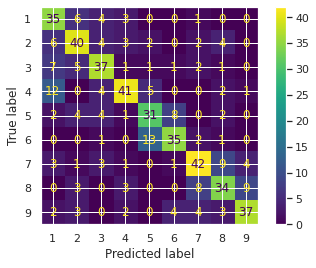

In [ ]:
cm = confusion_matrix(y_val, model_svm_4_labels, labels=sorted(df_4['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_4['Label'].unique()))
disp.plot()

**Euclidean distance - Confusion Matrix**

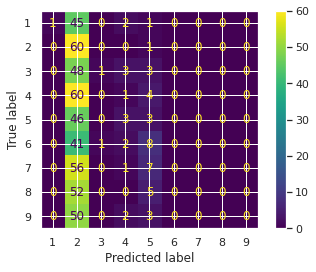

In [ ]:
cm = confusion_matrix(y_val, target_values, labels=sorted(df_4['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_4['Label'].unique()))
disp.plot()

###**Classifying rows from the test dataset using the approach with better performance (SVM)**

Since SVM performed better, we will classify the rows from the testing dataset. But first, we need to make sure that the dataset doesn't have empty cells.

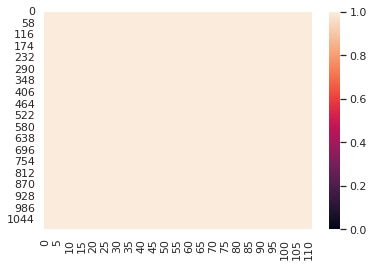

In [ ]:
#Importing the TestData4 dataset
df_4_test = pd.read_csv('TestData4.txt', sep='  ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_4_test.index:
  for j in range(len(df_4_test.columns)):
    if df_4_test[j][i] == 1e+99:
      df_4_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_4_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

Since there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
model_svm_4_labels_test = model_svm_4.predict(df_4_test)
#We export the target values from each row from the test dataset to a TXT file
with open("RoblesHernandezClassification4.txt", 'w') as f:
    f.write("\n".join(map(str, model_svm_4_labels_test)))

##**Classifying Dataset 5**

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

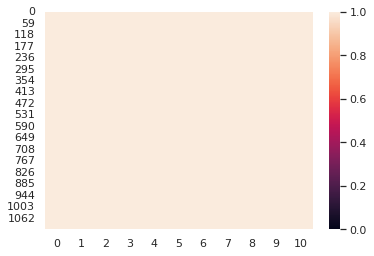

In [ ]:
#Importing the MissingData3 dataset
df_5 = pd.read_csv('TrainData5.txt', sep='   ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_5.index:
  for j in range(len(df_5.columns)):
    if df_5[j][i] == 1e+99:
      df_5[j][i] = np.nan

import numpy as np; 
np.random.seed(0)
import seaborn as sns; 
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_5.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are no empty cells in the dataset, therefore we can continue to merge the label column with the current dataset.

In [ ]:
#Merging training dataset with the label column
#Importing the TrainLabel5 data
df_5_label = pd.read_csv('TrainLabel5.txt', sep='\r\n', header = None)
df_5['Label'] = df_5_label[0]

###**Training process using SVM and Euclidean Distance**

**NOTE:** Two approaches will be implemented in order to select the one that performs better.

In [ ]:
#================ Training SVM Model ===================
X_train, X_val, y_train, y_val = train_test_split(df_5.iloc[:, :len(df_5.columns)-1], df_5.iloc[: , -1], test_size=0.15, random_state=42)

print("Building Support Vector Machines Model...")
model_svm_5 =svm.SVC(kernel = 'linear')
model_svm_5.fit(X_train, y_train)
pickle.dump(model_svm_5, open('SVM_5.pickle', 'wb'))
model_svm_5_labels = model_svm_5.predict(X_val)

model_svm_5_classification_report = classification_report(y_val, model_svm_5_labels)
print("\n\033[1mSupport Vector Machines- Performance metrics \n")
print(model_svm_5_classification_report)

print("Classifying rows using Euclidean distance...")
#Classifying rows using Euclidean distance where K = number of classes + 1
k_value = int(df_5.nunique()['Label'])+1
nearest_rows_index = []
nearest_rows_distance = []
target_values = []
for index,row in X_val.iterrows():
  #print("Current index: "+str(index))
  for index2,row2 in X_train.iterrows():
    #We calculate the distance for each column
    cumulative_sum = 0
    for i in range(len(X_val.columns)):
      cumulative_sum += math.pow(abs(row2[i]-row[i]),2)
    distance = math.sqrt(cumulative_sum)

    #If list of nearest rows is less than k_value, we add this
    if(len(nearest_rows_distance) < k_value):
      nearest_rows_index.append(index2)
      nearest_rows_distance.append(distance)
    else:
      #We check if the large value is greater than the current distance
      max_value = max(nearest_rows_distance)
      max_index = nearest_rows_distance.index(max_value)

      if(max_value > distance):
        nearest_rows_index[max_index] = int(index2)
        nearest_rows_distance[max_index] = distance
  #print("The row at the given index has a similarity with the following index: ")
  #print(nearest_rows_index)
  #print("Their respective distance values are: ")
  #print(nearest_rows_distance)

  #Now we get the counts for each class from each of the closest rows
  temp_label_counts = {}
  for i in range(len(nearest_rows_index)):
    current_label = df_5.iloc[[nearest_rows_index[i]]]['Label'].to_list()[0]
    if current_label in temp_label_counts:
        temp_label_counts[current_label] += 1
    else:
        temp_label_counts[current_label] = 1
  
  #We get the maximum value from the dictionary
  max_value = max(temp_label_counts, key=temp_label_counts.get)
  
  #We add the predicted class to the target list
  target_values.append(max_value)

model_ed_5_classification_report = classification_report(y_val, target_values)
print("\n\033[1mEuclidean Distance- Performance metrics \n")
print(model_ed_5_classification_report)    


Building Support Vector Machines Model...

Support Vector Machines- Performance metrics 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.71      0.79      0.75        77
           6       0.46      0.66      0.54        58
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00         4

    accuracy                           0.59       168
   macro avg       0.20      0.24      0.22       168
weighted avg       0.49      0.59      0.53       168

Classifying rows using Euclidean distance...

Euclidean Distance- Performance metrics 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.50      0.03      0.05        77
           6       0.34      0.95      0.50        58
        

###**Confusion Matrix (SVM and Euclidean distance)**

In the following plot, we can see the predicted labels vs true labels matrix obtained from both the SVM model and the Euclidean distance approach. 

**SVM - Confusion Matrix**

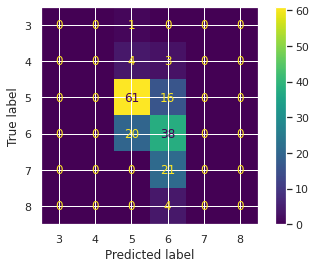

In [ ]:
cm = confusion_matrix(y_val, model_svm_5_labels, labels=sorted(df_5['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_5['Label'].unique()))
disp.plot()

**Euclidean distance - Confusion Matrix**

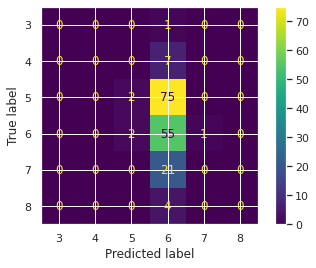

In [ ]:
cm = confusion_matrix(y_val, target_values, labels=sorted(df_5['Label'].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(df_5['Label'].unique()))
disp.plot()

###**Classifying rows from the test dataset using the approach with better performance (SVM)**

Since SVM performed better, we will classify the rows from the testing dataset. But first, we need to make sure that the dataset doesn't have empty cells.

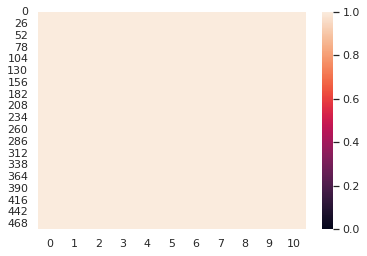

In [ ]:
#Importing the TestData4 dataset
df_5_test = pd.read_csv('TestData5.txt', sep='  ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_5_test.index:
  for j in range(len(df_5_test.columns)):
    if df_5_test[j][i] == 1e+99:
      df_5_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_5_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

Since there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
model_svm_5_labels_test = model_svm_5.predict(df_5_test)
#We export the target values from each row from the test dataset to a TXT file
with open("RoblesHernandezClassification5.txt", 'w') as f:
    f.write("\n".join(map(str, model_svm_5_labels_test)))

##**Classifying Dataset 6**

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

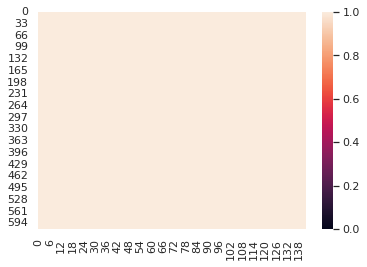

In [ ]:
#Importing the MissingData3 dataset
df_6 = pd.read_csv('TrainData6.txt', sep='  ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_6.index:
  for j in range(len(df_6.columns)):
    if df_6[j][i] == 1e+99:
      df_6[j][i] = np.nan

import numpy as np; 
np.random.seed(0)
import seaborn as sns; 
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_6.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are no empty cells in the dataset, therefore we can continue to merge the label column with the current dataset.

In [ ]:
#Merging training dataset with the label column
#Importing the TrainLabel5 data
df_6_label = pd.read_csv('TrainLabel6.txt', sep='\r\n', header = None)
df_6['Label'] = df_6_label[0]

###**Training Process (Linear Regression)**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, MultiOutputMixin
from sklearn.linear_model._base import LinearModel,_deprecate_normalize,_check_sample_weight
from sklearn.linear_model._base import _rescale_data,optimize,delayed,sparse,sparse_lsqr,Parallel,linalg,sp

#We define the Linear Regression Model class
class LinearRegression_Model(MultiOutputMixin, RegressorMixin, LinearModel):
    def __init__(self,*,fit_intercept=True,normalize="deprecated",copy_X=True,n_jobs=None,positive=False,):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive

    def fit(self, X, y, sample_weight=None):
        _normalize = _deprecate_normalize(self.normalize, default=False, estimator_name=self.__class__.__name__)
        n_jobs_ = self.n_jobs
        accept_sparse = False if self.positive else ["csr", "csc", "coo"]
        X, y = self._validate_data(X, y, accept_sparse=accept_sparse, y_numeric=True, multi_output=True)

        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X, dtype=X.dtype)

        X, y, X_offset, y_offset, X_scale = self._preprocess_data(
            X,
            y,
            fit_intercept=self.fit_intercept,
            normalize=_normalize,
            copy=self.copy_X,
            sample_weight=sample_weight,
            return_mean=True,)

        if sample_weight is not None:
            # NOTE: The sample weights can be implemented by rescaling.
            X, y = _rescale_data(X, y, sample_weight)

        if self.positive:
            if y.ndim < 2:
                self.coef_, self._residues = optimize.nnls(X, y)
            else:
                outs = Parallel(n_jobs=n_jobs_)(delayed(optimize.nnls)(X, y[:, j]) for j in range(y.shape[1]))
                self.coef_, self._residues = map(np.vstack, zip(*outs))
        elif sp.issparse(X):
            X_offset_scale = X_offset / X_scale

            def matvec(b):
                return X.dot(b) - b.dot(X_offset_scale)

            def rmatvec(b):
                return X.T.dot(b) - X_offset_scale * np.sum(b)

            X_centered = sparse.linalg.LinearOperator(shape=X.shape, matvec=matvec, rmatvec=rmatvec)

            if y.ndim < 2:
                out = sparse_lsqr(X_centered, y)
                self.coef_ = out[0]
                self._residues = out[3]
            else:
                outs = Parallel(n_jobs=n_jobs_)(delayed(sparse_lsqr)(X_centered, y[:, j].ravel())for j in range(y.shape[1]))
                self.coef_ = np.vstack([out[0] for out in outs])
                self._residues = np.vstack([out[3] for out in outs])
        else:
            self.coef_, self._residues, self.rank_, self.singular_ = linalg.lstsq(X, y)
            self.coef_ = self.coef_.T

        if y.ndim == 1:
            self.coef_ = np.ravel(self.coef_)
        self._set_intercept(X_offset, y_offset, X_scale)
        return self

#Once the Linear Regression class is implemented, we can call it
regressor = LinearRegression_Model(fit_intercept = False, normalize = True, positive = True)
X_train, X_val, y_train, y_val = train_test_split(df_6.iloc[:, :len(df_6.columns)-1], df_6.iloc[: , -1], test_size=0.20, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_val)

print("\n\033[1mLinear Regression- Root Mean Square Error \n")
print(math.sqrt(mean_squared_error(y_val,y_pred)))


Linear Regression- Root Mean Square Error 

1712279.495577965


###**Classifying rows using the Linear Regression model**

We will classify the rows from the testing dataset using the mentioned model. But first, we need to make sure that the dataset doesn't have empty cells.

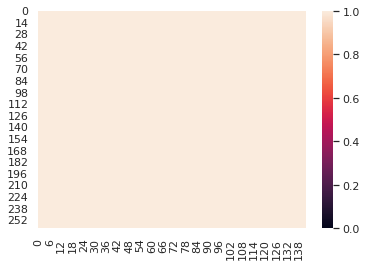

In [ ]:
#Importing the TestData4 dataset
df_6_test = pd.read_csv('TestData6.txt', sep='  ', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_6_test.index:
  for j in range(len(df_6_test.columns)):
    if df_6_test[j][i] == 1e+99:
      df_6_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_6_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

Since there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
model_lr_6_labels_test = regressor.predict(df_6_test)
#We export the target values from each row from the test dataset to a TXT file
with open("RoblesHernandezClassification6.txt", 'w') as f:
    f.write("\n".join(map(str, model_lr_6_labels_test)))

#**Machine Learning - Multi-label Classification**

Multi-label classification is a variant of the classification problem where multiple target labels must be assigned to each sample (Graduate Students Only). MultLabelTrainData contains 103 features with 500 samples. MultLabelTestData contains 103 features with 100 samples.

###**Filling missing values (if any)**
We need to know if there are any empty cells in the dataset. And if this is the case, the per-class average will be calculated for each feature missing for each record/row.

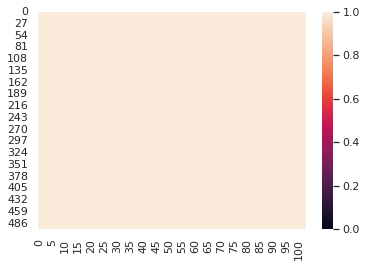

In [ ]:
#Importing the TrainingData4 dataset
df_7 = pd.read_csv('MultLabelTrainData.txt', sep='\t', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_7.index:
  for j in range(len(df_7.columns)):
    if df_7[j][i] == 1e+99:
      df_7[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_7.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

**NOTE:** As seen in the previous heatmap, there are no empty cells in the dataset, therefore we can continue to merge the label column with the current dataset. Since we have a multi-label dataset, we will create a copy of the dataset for each of the 14 labels. Therefore, we will train 14 copies of the same dataset but with a specific label (out of the 14 labels). And then, we will calculate the precision score average from each approach (SVM and Euclidean distance)

###**Training process using SVM and Euclidean Distance**

**NOTE:** Two approaches will be implemented in order to select the one that performs better.

In [ ]:
#Merging training dataset with the label column
#Importing the MultLabelTrainLabel data
df_7_label = pd.read_csv('MultLabelTrainLabel.txt', sep='\t', header = None)

accuracy_score_svm = 0.0
accuracy_score_ed = 0.0

models = []

for i in range(14):
  print("Training using the label from the column No. "+str(i))
  temp_df_7 = df_7
  temp_df_7['Label'] = df_7_label[i]

  #================ Training SVM Model ===================
  X_train, X_val, y_train, y_val = train_test_split(df_7.iloc[:, :len(df_7.columns)-1], df_7.iloc[: , -1], test_size=0.20, random_state=42)

  model_svm_7 =svm.SVC(kernel = 'linear')
  model_svm_7.fit(X_train, y_train)
  models.append(model_svm_7)
  model_svm_7_labels = model_svm_7.predict(X_val)

  accuracy_score_svm += accuracy_score(y_val, model_svm_7_labels)

  #Classifying rows using Euclidean distance where K = number of classes + 1
  k_value = int(df_7.nunique()['Label'])+1
  nearest_rows_index = []
  nearest_rows_distance = []
  target_values = []
  for index,row in X_val.iterrows():
    #print("Current index: "+str(index))
    for index2,row2 in X_train.iterrows():
      #We calculate the distance for each column
      cumulative_sum = 0
      for i in range(len(X_val.columns)):
        cumulative_sum += math.pow(abs(row2[i]-row[i]),2)
      distance = math.sqrt(cumulative_sum)

      #If list of nearest rows is less than k_value, we add this
      if(len(nearest_rows_distance) < k_value):
        nearest_rows_index.append(index2)
        nearest_rows_distance.append(distance)
      else:
        #We check if the large value is greater than the current distance
        max_value = max(nearest_rows_distance)
        max_index = nearest_rows_distance.index(max_value)

        if(max_value > distance):
          nearest_rows_index[max_index] = int(index2)
          nearest_rows_distance[max_index] = distance
    #print("The row at the given index has a similarity with the following index: ")
    #print(nearest_rows_index)
    #print("Their respective distance values are: ")
    #print(nearest_rows_distance)

    #Now we get the counts for each class from each of the closest rows
    temp_label_counts = {}
    for i in range(len(nearest_rows_index)):
      current_label = df_7.iloc[[nearest_rows_index[i]]]['Label'].to_list()[0]
      if current_label in temp_label_counts:
          temp_label_counts[current_label] += 1
      else:
          temp_label_counts[current_label] = 1
    
    #We get the maximum value from the dictionary
    max_value = max(temp_label_counts, key=temp_label_counts.get)
    
    #We add the predicted class to the target list
    target_values.append(max_value)

  accuracy_score_ed += accuracy_score(y_val, target_values)

accuracy_score_svm = accuracy_score_svm/14
accuracy_score_ed = accuracy_score_ed/14
print("Done!")
print("SVM - Overall Accuracy Score: "+str(accuracy_score_svm))
print("Euclidean distance - Overall Accuracy Score: "+str(accuracy_score_ed))

Training using the label from the column No. 0
Training using the label from the column No. 1
Training using the label from the column No. 2
Training using the label from the column No. 3
Training using the label from the column No. 4
Training using the label from the column No. 5
Training using the label from the column No. 6
Training using the label from the column No. 7
Training using the label from the column No. 8
Training using the label from the column No. 9
Training using the label from the column No. 10
Training using the label from the column No. 11
Training using the label from the column No. 12
Training using the label from the column No. 13
Done!
SVM - Overall Accuracy Score: 0.8085714285714285
Euclidean distance - Overall Accuracy Score: 0.7414285714285714


###**Classifying rows from the test dataset using the approach with better performance (SVM)**

Since SVM performed better, we will classify the rows from the testing dataset. But first, we need to make sure that the dataset doesn't have empty cells.

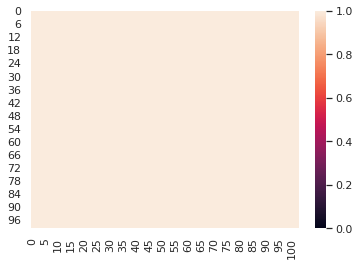

In [ ]:
#Importing the MultLabelTestData dataset
df_7_test = pd.read_csv('MultLabelTestData.txt', sep='\t', header = None)

#We replace the 1.00000e+99 with NaN values
for i in df_7_test.index:
  for j in range(len(df_7_test.columns)):
    if df_7_test[j][i] == 1e+99:
      df_7_test[j][i] = np.nan

np.random.seed(0)
sns.set_theme()

#Generating a heatmap highlighting all the empty spots
heatmap_df = (df_7_test.notnull()).astype('int')
data = heatmap_df.to_numpy()
ax = sns.heatmap(data, vmin=0, vmax=1)

Since there aren't empty cells in the testing dataset, we can continue classifying the rows from the testing dataset by using the SVM model.

In [ ]:
#We export the target values from each row from the test dataset to a TXT file
column_labels = []
for i in range(14):
  print("Classifying using the trained model for the label with column No. "+str(i))
  model_svm_7_labels_test = models[i].predict(df_7_test)
  column_labels.append(model_svm_7_labels_test)

df_7_classification = pd.DataFrame(columns=list(range(14)))
for i in range(14):
  df_7_classification[i] = column_labels[i]

df_7_classification.to_csv('RoblesHernandezMultiLabelClassification.txt', sep = '\t', header = None, index = None)
print("Done!")

Classifying using the trained model for the label with column No. 0
Classifying using the trained model for the label with column No. 1
Classifying using the trained model for the label with column No. 2
Classifying using the trained model for the label with column No. 3
Classifying using the trained model for the label with column No. 4
Classifying using the trained model for the label with column No. 5
Classifying using the trained model for the label with column No. 6
Classifying using the trained model for the label with column No. 7
Classifying using the trained model for the label with column No. 8
Classifying using the trained model for the label with column No. 9
Classifying using the trained model for the label with column No. 10
Classifying using the trained model for the label with column No. 11
Classifying using the trained model for the label with column No. 12
Classifying using the trained model for the label with column No. 13
Done!
